# Calibration

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

#data path
'000260'
'000333'
'20-1586'
'400'
'29-1289'
'data file numerations are like [20:1586:5]'
data_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000333/data_000000.txt"
half_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000332/data_"
data_paths=[half_path+str(i).zfill(6)+'.txt' for i in range(29,1289,1)]

#best detectors configuration for a given run ([2,3] or [0,1]?)
calib_config=[0,1,2,3]

In [3]:
cal1={}
false_events_counter=0
for data_path in data_paths:
    with open(data_path) as data_file:
        for line in data_file:
            row=line.strip().split()
            key=int(row[0])
            n_hits=int(row[1])
            if n_hits!=0:
                data_array=np.array(row[2:]).reshape((n_hits, 5))
                data_dict={}
                columns=['chamber', 'layer', 'xleft', 'xright', 'time']
                for i in range(2):
                    data_dict[columns[i]]=data_array[:, i].astype(int)
                for i in range(2,5):
                    data_dict[columns[i]]=data_array[:, i].astype(float)
                value=pd.DataFrame(data_dict)
                cal1[key]=value
            else:
                false_events_counter+=1
original_data_length=len(cal1)+false_events_counter
print(f'original data length: {original_data_length}')
print(f"null over nonnull events ratio (%) : {false_events_counter/(len(cal1)+false_events_counter)*100}%")

original data length: 41286
null over nonnull events ratio (%) : 20.40158891633968%


In [4]:
for event in cal1.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)
    event['center']=(event['xlg']+event['xrg'])/2
    event['valid_hit']=pd.Series(np.ones(len(event)).astype(bool))

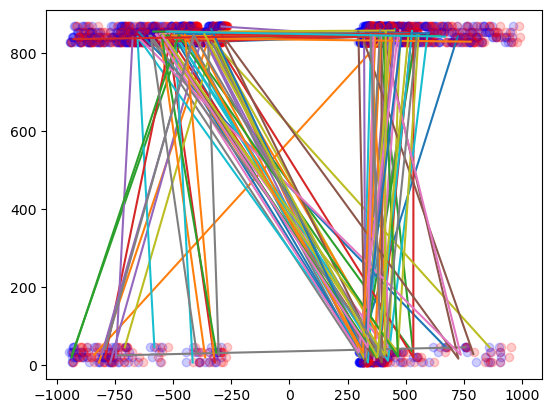

In [5]:
fig, ax=plt.subplots()
count=0
for event in cal1.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

[(7344, '[0, 2]'), (6723, '[0, 1, 2]'), (4325, '[0]'), (3224, '[2]'), (2704, '[0, 1, 2, 3]'), (1865, '[0, 1]'), (1351, '[0, 2, 3]'), (1189, '[1, 2]'), (1158, '[2, 3]'), (1006, '[1]'), (805, '[3]'), (406, '[0, 3]'), (348, '[1, 2, 3]'), (262, '[0, 1, 3]'), (153, '[1, 3]')]
('[0, 2]', '[0, 1, 2]', '[0]', '[2]', '[0, 1, 2, 3]', '[0, 1]', '[0, 2, 3]', '[1, 2]', '[2, 3]', '[1]', '[3]', '[0, 3]', '[1, 2, 3]', '[0, 1, 3]', '[1, 3]') (7344, 6723, 4325, 3224, 2704, 1865, 1351, 1189, 1158, 1006, 805, 406, 348, 262, 153)


Text(0.5, 1.0, 'number of events for any combination of triggered chambers')

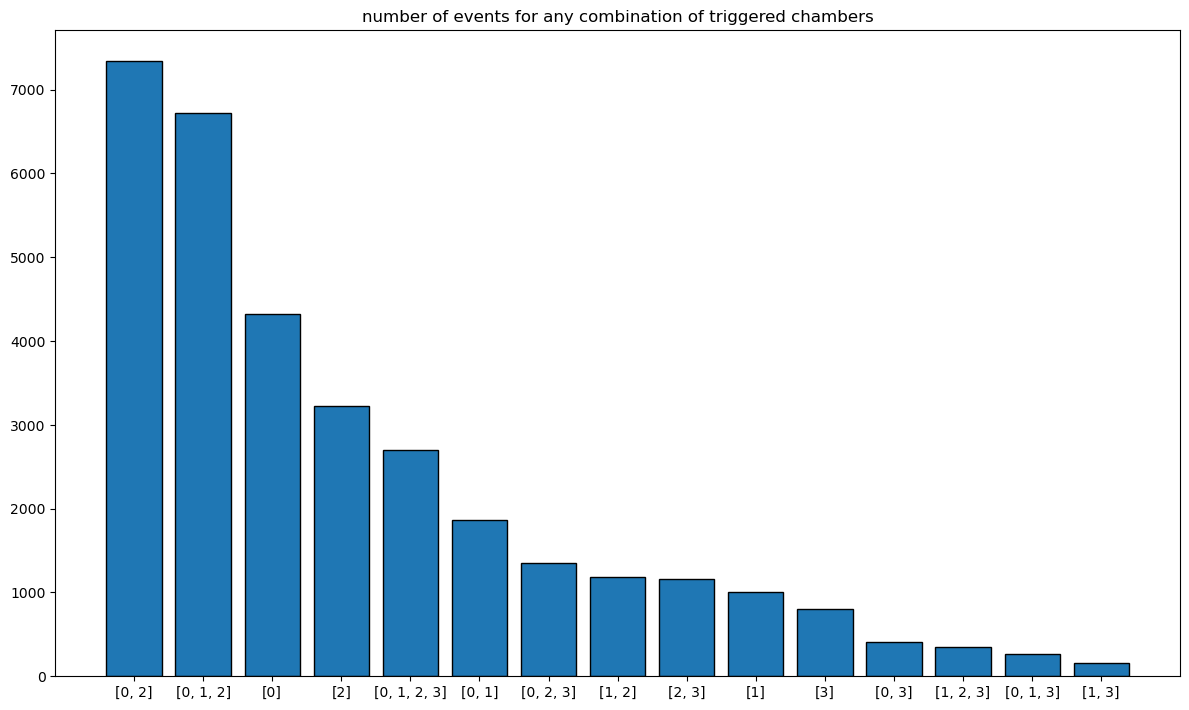

In [6]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in cal1.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_title('number of events for any combination of triggered chambers')

average n_hits per event: 37.142011834319526
 most frequent n_hits per event 13



Text(0.5, 1.0, 'number of events vs number of hits for the [0, 1, 2, 3] chambers events')

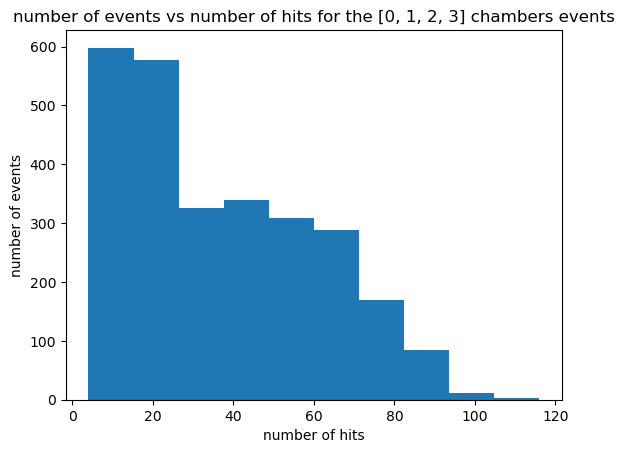

In [7]:
n_hits_per_event=[len(event) for event in cal1.values() if sorted(np.unique(event['chamber']))==calib_config]
print(f'average n_hits per event: {np.mean(n_hits_per_event)}')
print(f' most frequent n_hits per event {np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])]}')
#plt.hist(n_hits_per_event, bins=33)
plt.hist(n_hits_per_event)
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title(f'number of events vs number of hits for the {calib_config} chambers events')

In [8]:
'''
print(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))
print(cal1[4])
'''

"\nprint(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))\nprint(cal1[4])\n"

In [9]:
print(list((np.abs(event['xleft']-event['xright'])>XCELL).index))
print(cal1[1].index)

[0, 1, 2, 3, 4]
RangeIndex(start=0, stop=8, step=1)


In [10]:
#filters for event selection

def desired_chamber_config(event):
    '''
    print('DCC event: ',event[event['valid_hit']==True])
    print('DCC chamber col', event[event['valid_hit']==True]['chamber'])
    print('DCC config', sorted(np.unique(event[event['valid_hit']==True]['chamber'])))
    '''
    return sorted(np.unique(event['chamber']))==calib_config

def desired_chamber_config_only_valids(event):
    return sorted(np.unique(event[event['valid_hit']==True]['chamber']))==calib_config

def three_layers_per_det(event):
    return not np.any(event[event['valid_hit']==True].groupby('chamber')['layer'].nunique().reset_index()['layer']<3) and desired_chamber_config_only_valids(event)

def one_hit_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']!=1)

def max_two_hits_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']>2)

def max_two_layers_with_more_than_one_hit(event):
    return not np.count_nonzero(event.groupby(['chamber', 'layer']).count().reset_index()['time']>1)>2

    '''
    print('1', np.array(event['valid_hit']==True))
    print('2', np.array(event[event['valid_hit']==True].groupby('chamber')['layer']))
    print('3', event[event['valid_hit']==True].groupby('chamber')['layer'].value_counts().reset_index())
    print('4', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].value_counts().reset_index()))
    print('5', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1])
    print('6', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1)
    print('7', (np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1).count()<=2)
    return (np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1).count()<=2
    '''

#filters for (bad) hit selection

def coordinates_outside_cell(event):
    return list(event[np.abs(event['xleft']-event['xright'])>XCELL].index)

def deviant_hit(event): 
    n_sigmas_treshhold=2
    bad_indices=[]
    def other_hits_mu_std(out_index, event):
        index=list(event[event['chamber']==event.loc[out_index]['chamber']].index)
        index.remove(out_index)
        print('index', index)
        return event.loc[index]['center'].mean(), event.loc[index]['center'].std() 
        
    for out_index, row in event.iterrows():
        print('out_index', out_index)
        mu, std=other_hits_mu_std(out_index, event)
        print(row['center'], mu, abs(row['center']-mu), n_sigmas_treshhold*std, XCELL)
        if abs(row['center']-mu)> max(n_sigmas_treshhold*std, XCELL):
            bad_indices.append(out_index)
    return bad_indices

#filter applicators:

def event_filter(keys_list, e_filter): #modifies the list of keys
    return list(filter(lambda key : e_filter(cal1[key]), keys_list))

def hit_filter(keys_list, h_filter): #modifies in place the 'valid_hit' column of dataset
    for key in keys_list:
        event=cal1[key]
        #the "bad" filters return lists of "bad" hit indices, to be set to false. So the lists can just be concatenate with "+"
        bad_rows_indices_list=h_filter(event)
        print('badrowsindes: ',key, bad_rows_indices_list)
        #print('before:', event)
        event.loc[bad_rows_indices_list,'valid_hit'] = False
        #print('after:', event)


In [11]:
#FILTERS APPLICATION (both event_filters and hit_filters):
#NB: THE ORDER MATTERS!
impeccable_events=event_filter(cal1, desired_chamber_config)
impeccable_events=event_filter(impeccable_events, max_two_layers_with_more_than_one_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, coordinates_outside_cell)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, deviant_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
impeccable_events=event_filter(impeccable_events, three_layers_per_det)
#impeccable_events=event_filter(cal1, desired_chamber_config)

print(impeccable_events)
print(len(impeccable_events))
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")

ratio between impeccable events and nonzerohit events 0.012689042388096036
 ratio between impeccable events and original dataset events 0.01010027612265659
badrowsindes:  57 []
badrowsindes:  95 []
badrowsindes:  273 []
badrowsindes:  352 []
badrowsindes:  360 []
badrowsindes:  413 [7, 8]
badrowsindes:  803 []
badrowsindes:  825 [0]
badrowsindes:  862 []
badrowsindes:  886 []
badrowsindes:  967 []
badrowsindes:  971 [0, 2]
badrowsindes:  1355 []
badrowsindes:  1473 []
badrowsindes:  1487 []
badrowsindes:  1521 []
badrowsindes:  1886 [0]
badrowsindes:  1891 []
badrowsindes:  2336 []
badrowsindes:  2869 []
badrowsindes:  3117 []
badrowsindes:  3171 []
badrowsindes:  3219 []
badrowsindes:  3580 [7]
badrowsindes:  3704 [5]
badrowsindes:  3806 [4]
badrowsindes:  3809 []
badrowsindes:  4081 []
badrowsindes:  4199 []
badrowsindes:  4265 []
badrowsindes:  4388 []
badrowsindes:  4722 [5]
badrowsindes:  4797 []
badrowsindes:  4889 []
badrowsindes:  5152 []
badrowsindes:  5241 [1]
badrowsindes:  

In [12]:

event=cal1[4944]
#print( 'mu std', event.loc[[7,8,9]]['center'].mean(), event.loc[[7,8,9]]['center'].std() )
print(event)
print()
hit_filter([4944], coordinates_outside_cell)
#event_plotter(2)
print(coordinates_outside_cell(event))
print(event)
print('!!!', max_two_layers_with_more_than_one_hit(event))

    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         1      3  188.90  189.10    2.0  758.50  758.30   19.5   758.4   
1         2      2  501.10  506.90   54.0 -768.50 -774.30  856.0  -771.4   
2         2      2  457.70  466.30   80.0 -725.10 -733.70  856.0  -729.4   
3         2      4  283.20  304.80  200.0 -550.60 -572.20  830.0  -561.4   
4         2      4  456.00  468.00  111.0 -723.40 -735.40  830.0  -729.4   
5         2      1  466.30  499.70  310.0 -733.70 -767.10  869.0  -750.4   
6         2      3  470.40  495.60  235.0 -737.80 -763.00  843.0  -750.4   
7         2      2  441.70  482.30  377.0 -709.10 -749.70  856.0  -729.4   
8         3      2  377.10  378.90   16.0 -638.60 -640.40   32.5  -639.5   
9         3      1  440.70  441.30    6.0 -702.20 -702.80   45.5  -702.5   
10        3      4  504.00  504.00   -3.0 -765.50 -765.50    6.5  -765.5   
11        3      3  438.10  443.90   54.0 -699.60 -705.40   19.5  -702.5   
12        3 

In [13]:

print(cal1[95]['layer'].unique())
print(cal1[95])


[1 2 4 3]
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      1  604.200  613.80   90.0  390.000  380.40  869.0  385.2000   
1         0      2  624.900  635.10   96.0  369.300  359.10  856.0  364.2000   
2         0      4  625.900  634.10   76.0  368.300  360.10  830.0  364.2000   
3         0      3  593.700  624.30  285.0  400.500  369.90  843.0  385.2000   
4         1      3  607.400  610.60   30.0  340.000  336.80   19.5  338.4000   
5         1      2  625.200  634.80   89.0  322.200  312.60   32.5  317.4000   
6         1      1  599.100  618.90  185.0  348.300  328.50   45.5  338.4000   
7         1      2  570.000  606.00  334.0  377.400  341.40   32.5  359.4000   
8         1      4  568.900  607.10  356.0  378.500  340.30    6.5  359.4000   
9         2      1   59.790   66.21   60.0 -327.190 -333.61  869.0 -330.4000   
10        2      3   60.510   65.49   46.0 -327.910 -332.89  843.0 -330.4000   
11        2      2   67.370  1

In [14]:
from itertools import product
from scipy.stats import pearsonr
from math import atan2


def angle(A,B, C=None):
    #takes two points A and B with coordinates A=(xA,yA)... and return the angle on the plane in radiants
    #OR takes three points A, B, C with coordinates A=(xA,yA).. and return the difference angle BC^-AB^
    if C==None:
        return np.pi/2-atan2(A[1]-B[1], A[0]-B[0])
    else:
        difference=np.abs(angle(B,C)-angle(A,B))
        return min(2*np.pi-difference, difference)

def zigzaginess(path):
    try:
        if(len(path)>=3):
            squaresum=0
            for i in range(len(path)-2):
                A=path[i]
                B=path[i+1]
                C=path[i+2]
                squaresum+=(angle(B,C)-angle(A,B))**2
            return squaresum
        else:
            raise Exception("Error: path of less than 3 points")
    except Exception as err:
        print(err)
    
def tangent_zigzaginess(path):
    try:
        if(len(path)>=3):

            deviation_sum=0
            length_sum=0

            for i in range(len(path)-2):
                A=path[i]
                B=path[i+1]
                C=path[i+2]
                deviation_sum+=(atan2(B[0]-C[0], B[1]-C[1])-atan2(A[0]-B[0], A[1]-B[1]))**2

            for i in range(len(path)-1):
                A=path[i]
                B=path[i+1]
                length_sum+=(B[0]-A[0])**2+(B[1]-A[1])**2
            length_weight=0

            A,B,C,D=path[0], path[1], path[-2], path[-1]
            first_last_deviation=(atan2(C[0]-D[0], C[1]-D[1])-atan2(A[0]-B[0], A[1]-B[1]))**2
            fldev_weight=1

            return deviation_sum+fldev_weight*first_last_deviation+length_weight*length_sum
        else:
            raise Exception("Error: path of less than 3 points")
    except Exception as err:
        print(err)

def opt_track(event, chamber):
    valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
    valid_subevent=valid_subevent.sort_values(by='zg')

    axes=[]
    for layer in np.sort(valid_subevent['layer'].unique()):
        axis=[]
        for index, row in valid_subevent[event['layer']==layer].iterrows():
            for coord in [row['xlg'], row['xrg']]:
                axis.append((coord, row['zg']))
        axes.append(axis)

    #axes=[['xrg', 'xlg']]*len(valid_subevent)
    paths=list(product(*axes))
    
    #paths=[[(np.array(valid_subevent[xc[i]])[i], np.array(valid_subevent['zg'])[i] ) for i in range(len(valid_subevent))] for xc in xcs]
    #sorting_function=(lambda path : abs(pearsonr(*zip(*path)).pvalue))
    #sorting_function=(lambda path : abs(np.corrcoef(*zip(*path))[0,1]))
    straightness_function=lambda x: -tangent_zigzaginess(x)
    best_path=max(paths, key=straightness_function)
    return best_path

In [ ]:
from matplotlib.patches import Rectangle
from scipy.stats import linregress

def event_plotter(event_number, plot_ax=None):
    event_is_tricky=False
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    if ax==None:
        fig, ax=plt.subplots(figsize=(12,10))
    else:
        ax=plot_ax

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    ax.scatter(my_event['xlg'], my_event['zg'], color='blue')
    ax.scatter(my_event['xrg'], my_event['zg'], color='red')
    XRANGE=[-1000, 1000]
    YRANGE=[-100, 950]
    ax.set_xlim(XRANGE)
    ax.set_ylim(YRANGE)
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)

    def tracker_fitter(in_line_chambers):
        is_tricky=False
        print('chamber:', in_line_chambers[0])
        (xu,zu)=zip(*opt_track(my_event, in_line_chambers[0]))
        print('chamber:', in_line_chambers[1])
        (xd,zd)=zip(*opt_track(my_event, in_line_chambers[1]))
        x=np.concatenate([xu,xd])
        z=np.concatenate([zu,zd])

        resu=linregress(zu,xu)
        resd=linregress(zd,xd)
        res=linregress(z,x)

        xspace=np.linspace(*XRANGE, 1000)
        ax.plot(xspace, 1/resu.slope*xspace-resu.intercept/resu.slope, '--')
        ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')
        ax.plot(xspace, 1/res.slope*xspace-res.intercept/res.slope, color='black')

        angle_tresh=np.pi/5
        ang_coef_tresh=0.5
        #if abs(resu.slope)>ang_coef_tresh or abs(resd.slope)>ang_coef_tresh: event_is_tricky=True
        if abs(np.arctan(resu.slope)-np.arctan(res.slope))>angle_tresh or abs(np.arctan(resd.slope)-np.arctan(res.slope))>angle_tresh: is_tricky=True
        #ax.plot(xu,zu)
        #ax.plot(xd,zd)
        return is_tricky
    
    for i in range(0,len(calib_config),2):
        is_tricky=tracker_fitter(calib_config[i:i+2])
        if is_tricky: event_is_tricky=True

    if plot_ax==None:
        plt.show()
    print(event_number)
    print(my_event)

    return event_number, event_is_tricky

tricky_events=[]



for k in range(min([5, len(impeccable_events)])):
    print(k)
    print(impeccable_events[k])
    print(cal1[impeccable_events[k]])
    event_number, event_is_tricky=event_plotter(impeccable_events[k])
    if event_is_tricky:
        tricky_events.append(event_number)
print('TRICKY EVENTS: ', tricky_events)
print(f'precentage of good events showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/len(impeccable_events)*100}%')
print(f'precentage of events in original dataset showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/original_data_length*100}%')
#event_plotter(6577)
#event_plotter(6577)

In [ ]:
fig,ax=plt.subplots()

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory

    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      1  566.10  567.90   17.0  428.10  426.30  869.0  427.200   
1         0      3  566.20  567.80   15.0  428.00  426.40  843.0  427.200   
2         0      3  560.60  573.40  120.0  433.60  420.80  843.0  427.200   
3         0      1  642.30  659.70  161.0  351.90  334.50  869.0  343.200   
4         0      3  641.40  660.60  179.0  352.80  333.60  843.0  343.200   
5         0      4  659.00  685.00  240.0  335.20  309.20  830.0  322.200   
6         1      1  566.20  567.80   16.0  381.20  379.60   45.5  380.400   
7         1      3  566.00  568.00   18.0  381.40  379.40   19.5  380.400   
8         1      4  568.90  607.10  356.0  378.50  340.30    6.5  359.400   
9         2      2   80.20   87.80   70.0 -347.60 -355.20  856.0 -351.400   
10        2      4   81.46   86.54   47.0 -348.86 -353.94  830.0 -351.400   
11        2      3   88.15  121.90  313.0 -355.55 -389.30  843.0 -372.425   

/tmp/ipykernel_1663910/949233512.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1663910/949233512.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


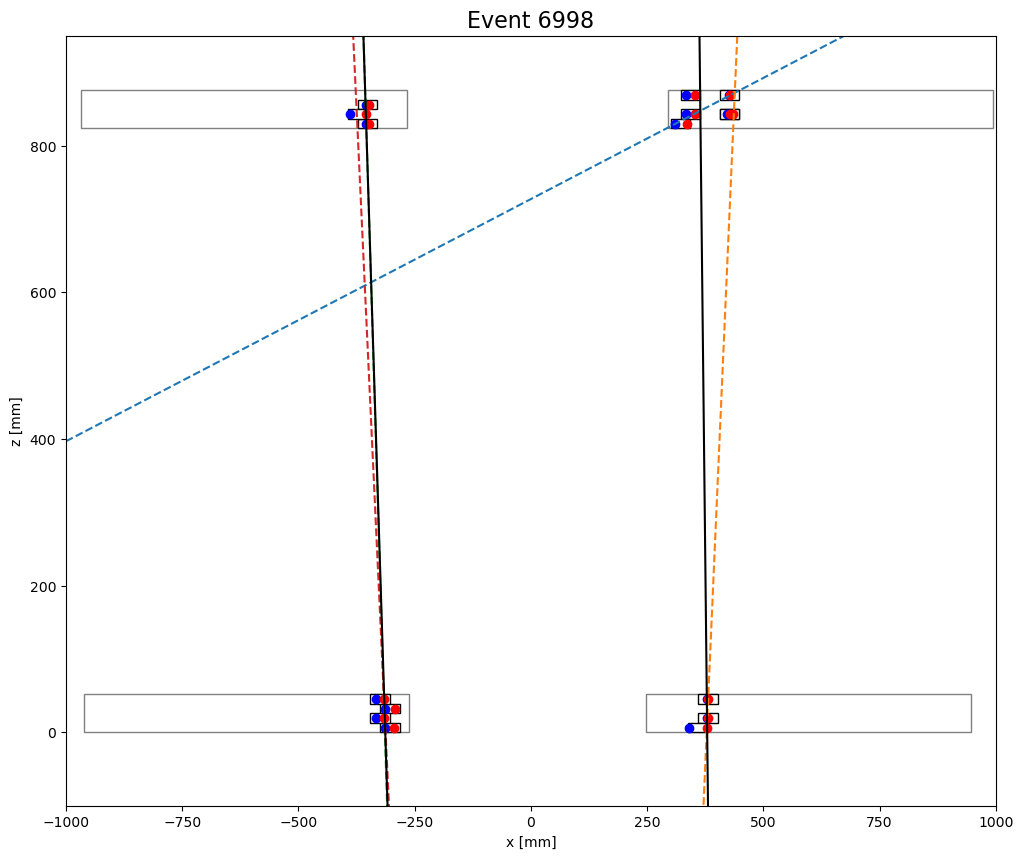

6998
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      1  566.10  567.90   17.0  428.10  426.30  869.0  427.200   
1         0      3  566.20  567.80   15.0  428.00  426.40  843.0  427.200   
2         0      3  560.60  573.40  120.0  433.60  420.80  843.0  427.200   
3         0      1  642.30  659.70  161.0  351.90  334.50  869.0  343.200   
4         0      3  641.40  660.60  179.0  352.80  333.60  843.0  343.200   
5         0      4  659.00  685.00  240.0  335.20  309.20  830.0  322.200   
6         1      1  566.20  567.80   16.0  381.20  379.60   45.5  380.400   
7         1      3  566.00  568.00   18.0  381.40  379.40   19.5  380.400   
8         1      4  568.90  607.10  356.0  378.50  340.30    6.5  359.400   
9         2      2   80.20   87.80   70.0 -347.60 -355.20  856.0 -351.400   
10        2      4   81.46   86.54   47.0 -348.86 -353.94  830.0 -351.400   
11        2      3   88.15  121.90  313.0 -355.55 -389.30  843.0 -372.4

/tmp/ipykernel_1663910/949233512.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1663910/949233512.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


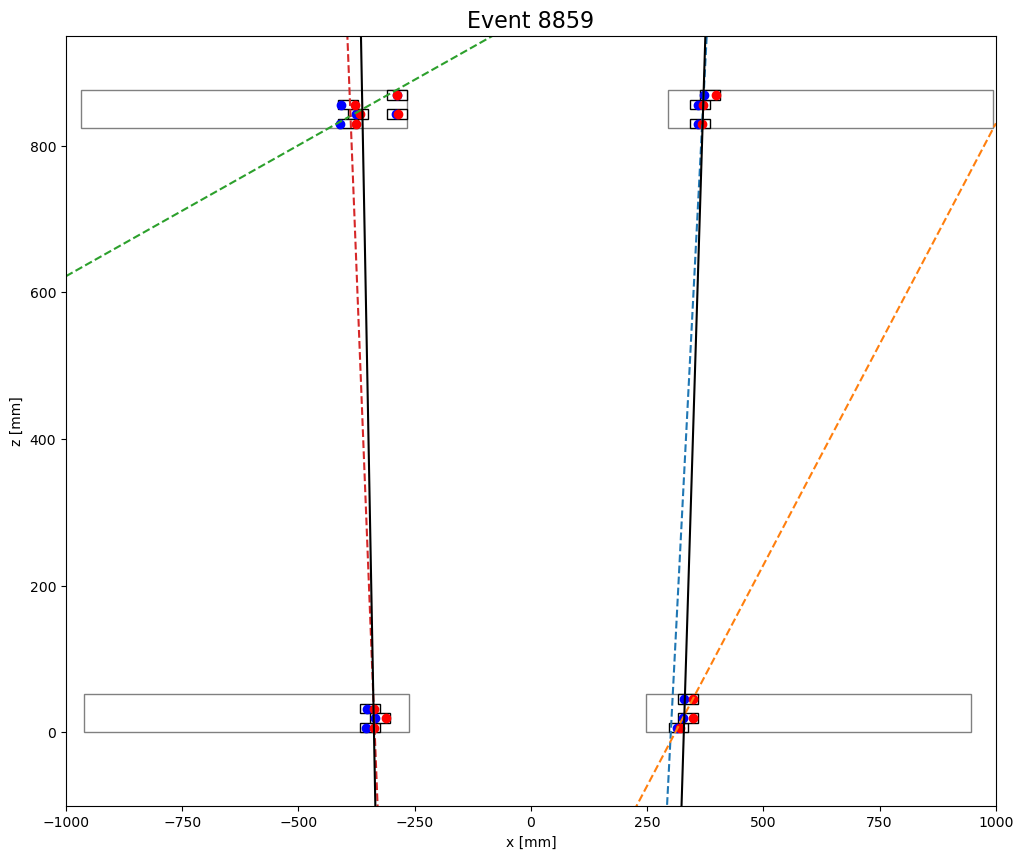

8859
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  624.10  635.90  110.0  370.10  358.30  856.0   364.2   
1         0      4  625.70  634.30   80.0  368.50  359.90  830.0   364.2   
2         0      1  595.60  622.40  248.0  398.60  371.80  869.0   385.2   
3         1      4  627.80  632.20   41.0  319.60  315.20    6.5   317.4   
4         1      1  599.50  618.50  176.0  347.90  328.90   45.5   338.4   
5         1      3  598.20  619.80  200.0  349.20  327.60   19.5   338.4   
6         2      1   21.00   21.00   -6.0 -288.40 -288.40  869.0  -288.4   
7         2      3  101.20  108.80   70.0 -368.60 -376.20  843.0  -372.4   
8         2      3   19.09   22.91   36.0 -286.49 -290.31  843.0  -288.4   
9         2      2  110.60  141.40  286.0 -378.00 -408.80  856.0  -393.4   
10        2      4  109.10  142.90  313.0 -376.50 -410.30  830.0  -393.4   
11        3      2   76.79   91.21  134.0 -338.29 -352.71   32.5  -345.5   
12     

/tmp/ipykernel_1663910/949233512.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1663910/949233512.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


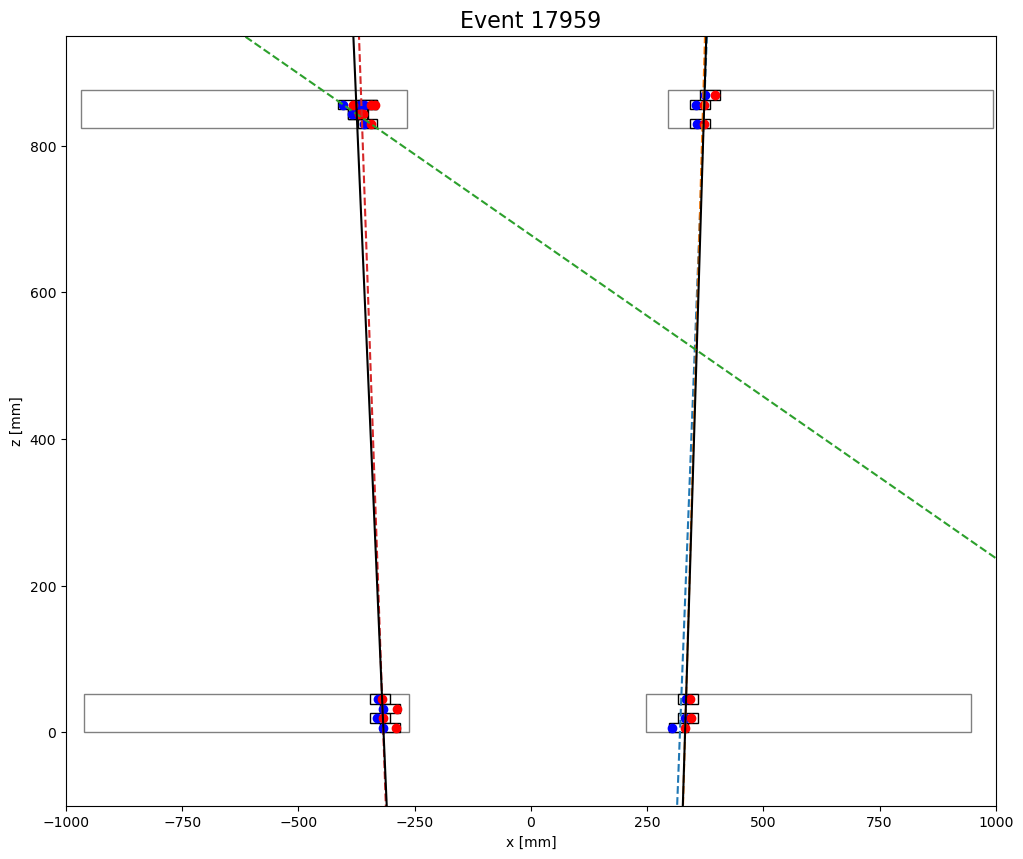

17959
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      4  623.00  637.00  130.0  371.20  357.20  830.0  364.200   
1         0      2  621.50  638.50  157.0  372.70  355.70  856.0  364.200   
2         0      1  597.40  620.60  215.0  396.80  373.60  869.0  385.200   
3         1      1  604.30  613.70   88.0  343.10  333.70   45.5  338.400   
4         1      3  602.90  615.10  114.0  344.50  332.30   19.5  338.400   
5         1      4  615.40  644.60  271.0  332.00  302.80    6.5  317.400   
6         2      4   77.29   90.71  125.0 -344.69 -358.11  830.0 -351.400   
7         2      3  103.10  106.90   36.0 -370.50 -374.30  843.0 -372.400   
8         2      2  115.70  136.30  190.0 -383.10 -403.70  856.0 -393.400   
9         2      2   75.99   92.01  149.0 -343.39 -359.41  856.0 -351.400   
10        2      3   92.81  117.20  226.0 -360.21 -384.60  843.0 -372.405   
11        2      2   68.72   99.28  284.0 -336.12 -366.68  856.0 -351.

/tmp/ipykernel_1663910/949233512.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1663910/949233512.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


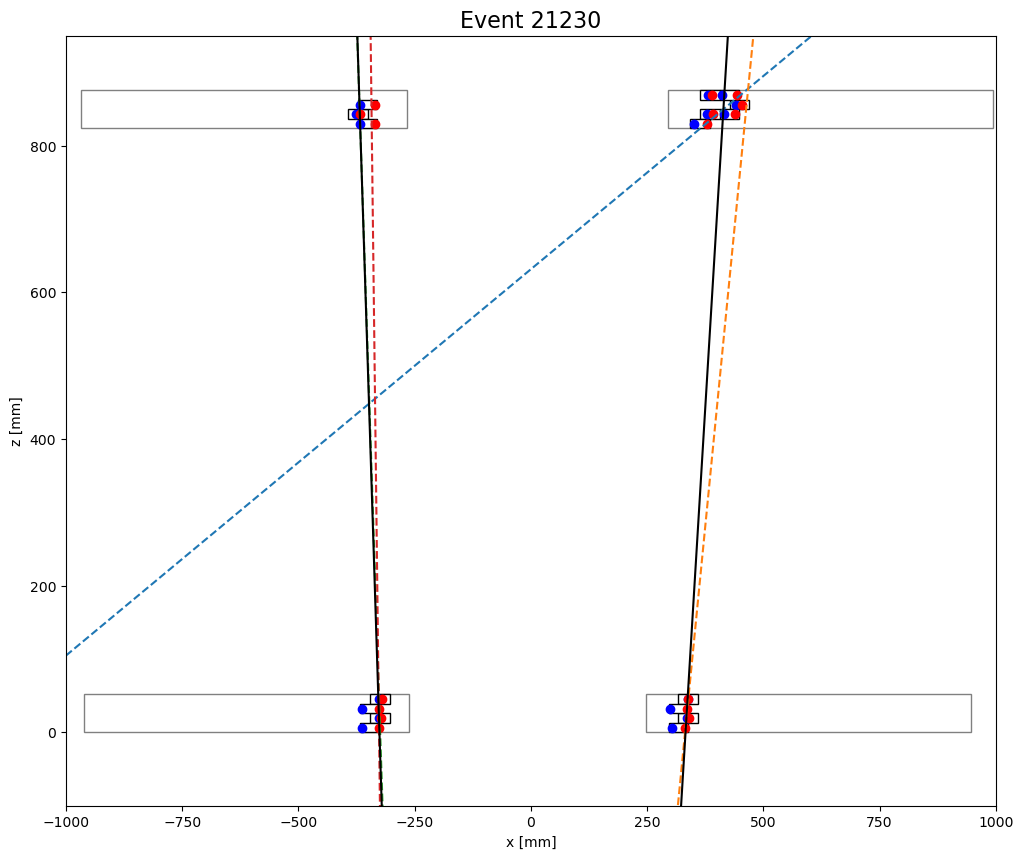

21230
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      2  539.30  552.70  125.0  454.90  441.50  856.0  448.200   
1         0      1  604.70  613.30   80.0  389.50  380.90  869.0  385.200   
2         0      3  555.60  578.40  212.0  438.60  415.80  843.0  427.200   
3         0      3  603.20  614.80  107.0  391.00  379.40  843.0  385.200   
4         0      1  550.80  583.20  301.0  443.40  411.00  869.0  427.200   
5         0      4  616.20  643.80  257.0  378.00  350.40  830.0  364.200   
6         1      1  609.00  609.00   -5.0  338.40  338.40   45.5  338.400   
7         1      3  606.60  611.40   45.0  340.80  336.00   19.5  338.400   
8         1      4  615.70  644.30  266.0  331.70  303.10    6.5  317.400   
9         1      2  611.40  648.60  346.0  336.00  298.80   32.5  317.400   
10        2      3  101.20  108.80   70.0 -368.60 -376.20  843.0 -372.400   
11        2      2   67.10  100.90  314.0 -334.50 -368.30  856.0 -351.

/tmp/ipykernel_1663910/949233512.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1663910/949233512.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


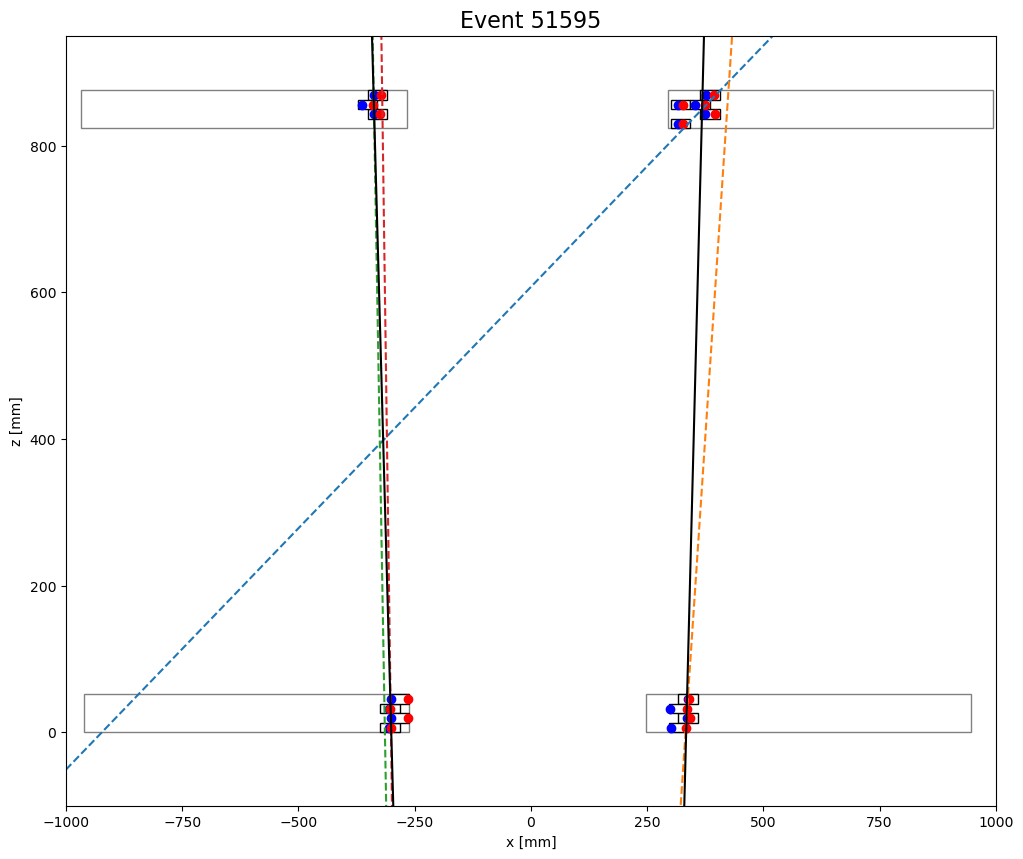

51595
    chamber  layer    xleft  xright   time      xrg     xlg     zg   center  \
0         0      2  666.500  677.50  101.0  327.700  316.70  856.0  322.200   
1         0      1  600.900  617.10  151.0  393.300  377.10  869.0  385.200   
2         0      4  666.800  677.20   97.0  327.400  317.00  830.0  322.200   
3         0      3  599.100  618.90  183.0  395.100  375.30  843.0  385.200   
4         0      2  619.100  640.90  203.0  375.100  353.30  856.0  364.200   
5         1      1  607.900  610.10   20.0  339.500  337.30   45.5  338.400   
6         1      3  606.300  611.70   50.0  341.100  335.70   19.5  338.400   
7         1      4  614.700  645.30  285.0  332.700  302.10    6.5  317.400   
8         1      2  611.800  648.20  338.0  335.600  299.20   32.5  317.400   
9         2      3   56.600   69.40  119.0 -324.000 -336.80  843.0 -330.400   
10        2      1   55.880   70.12  132.0 -323.280 -337.52  869.0 -330.400   
11        2      2   71.320   96.68  236.0 -33

/tmp/ipykernel_1663910/949233512.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1663910/949233512.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


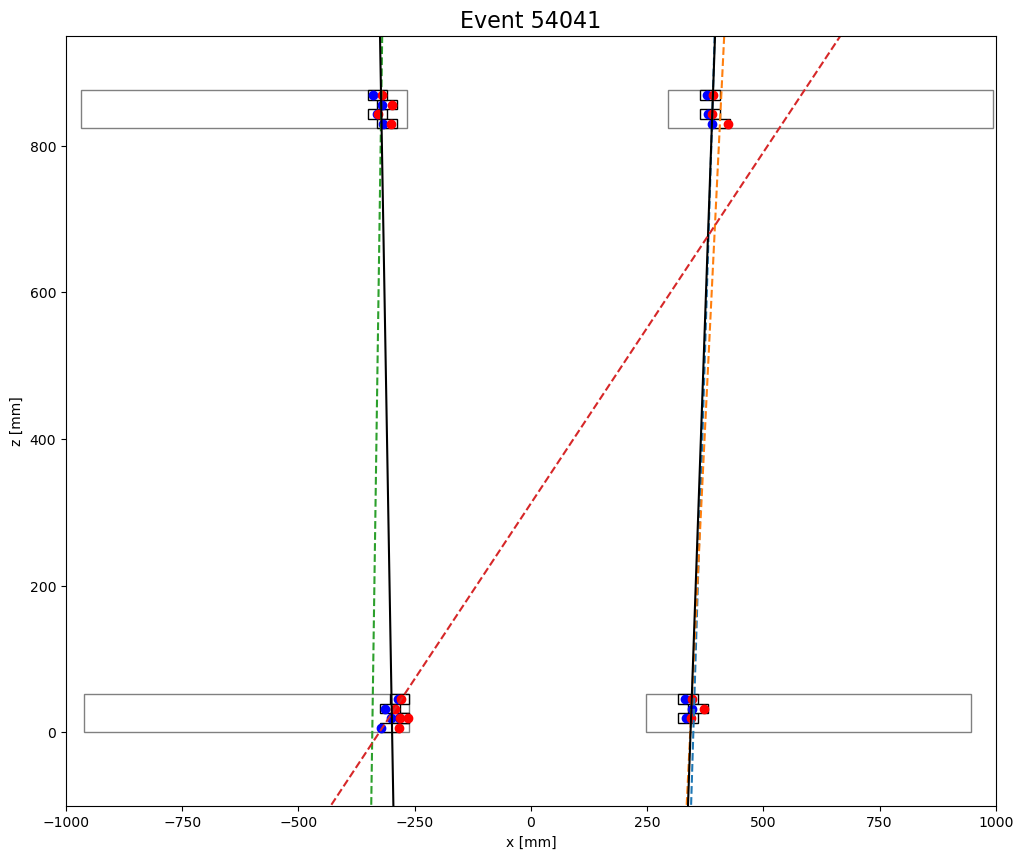

54041
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      1  602.900  615.10  114.0  391.300  379.10  869.0  385.2000   
1         0      3  604.100  613.90   90.0  390.100  380.30  843.0  385.2000   
2         0      4  571.200  604.80  311.0  423.000  389.40  830.0  406.2000   
3         1      3  603.700  614.30   99.0  343.700  333.10   19.5  338.4000   
4         1      1  601.700  616.30  136.0  345.700  331.10   45.5  338.4000   
5         1      2  574.600  601.40  249.0  372.800  346.00   32.5  359.4000   
6         2      3   62.080   63.92   17.0 -329.480 -331.32  843.0 -330.4000   
7         2      2   31.830   52.17  189.0 -299.230 -319.57  856.0 -309.4000   
8         2      4   33.000   51.00  167.0 -300.400 -318.40  830.0 -309.4000   
9         2      1   53.330   72.67  180.0 -320.730 -340.07  869.0 -330.4000   
10        3      3   20.170   21.83   16.0 -281.670 -283.33   19.5 -282.5000   
11        3      1   18.640   23.3

In [16]:
numbers_to_check=[52454]
numbers_to_check=tricky_events
for number_to_check in numbers_to_check:
    print(cal1[number_to_check])
    print('filter result: ', three_layers_per_det(cal1[number_to_check]))
    event_plotter(number_to_check)
